# **Entrenamiento y evaluación**

## **Importación de Librerías**

In [9]:
import os
import warnings
warnings.filterwarnings("ignore")
import time
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

## **Carga de datos y limpieza de NA**

Realizamos la respectiva carga de los datos y limpieza de datos faltantes realizados en el análisis exploratorio

In [12]:
ruta_data = os.path.join("..", "data/churn.csv")


df = pd.read_csv(ruta_data)

#limpieza de NA realizada en análisis exploratorio
df.replace(' ', np.nan, inplace=True)
df = df.dropna()

## **Tratamiento de datos**


Se realiza un procesamiento estructurado de variables que incluye: la identificación y codificación numérica (0/1) de variables binarias mediante mapeo de categorías, la conversión explícita a float y selección de variables numéricas continuas.

In [13]:
#binarias

binarias = [col for col in df.columns if df[col].nunique() == 2]
map_bin = {
    'Yes': 1, 'Male': 1,
    'No': 0, 'Female': 0,
}

df[binarias] = df[binarias].replace(map_bin)
df[binarias]

#numéricas

df["TotalCharges"] = df["TotalCharges"].astype(float)
numericas = ["tenure","MonthlyCharges","TotalCharges"]

#categóricas

categoricas = [col for col in df.columns if col not in (numericas+binarias)]

## **Separación conjuntos Train - Test**

Para garantizar una evaluación rigurosa del modelo optimizado, se divide el dataset en conjuntos de entrenamiento y prueba. Los datos de entrenamiento (`X_train`, `y_train`) se utilizan para el reentrenamiento del modelo con la configuración óptima de hiperparámetros, mientras que el conjunto de prueba (`X_test`, `y_test`) se reserva exclusivamente para la evaluación final, proporcionando así una estimación no sesgada del rendimiento en datos no vistos.

In [14]:
from sklearn.model_selection import train_test_split

binarias = [col for col in binarias if col != "Churn"]
categoricas = [col for col in categoricas if col != "customerID"]

X = df.drop(["Churn", "customerID"], axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Preprocesamiento**

Dado que los algoritmos basados en árboles son inherentemente invariantes a la escala de las variables, se mantuvieron las características numéricas en su formato original mediante la estrategia `passthrough`, aplicando únicamente codificación `one-hot` a las variables categóricas para garantizar su representación adecuada sin introducir órdenes artificiales. 

Todos los transformadores fueron configurados con el parámetro `handle_unknown='ignore'` para asegurar robustez frente a categorías no observadas durante el entrenamiento, preservando así la integridad operativa del pipeline en entornos de producción con datos potencialmente cambiantes.

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# RANDOM FOREST ----------------------------------------------------------------

preprocessor_random_forest = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numericas + binarias), 
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categoricas)
    ]
)

# XGBOOST ----------------------------------------------------------------

preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numericas + binarias),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categoricas)
    ]
)

# CATBOOST ----------------------------------------------------------------
cat_features_indices = [X.columns.get_loc(col) for col in categoricas]

preprocessor_catboost = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numericas + binarias),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categoricas) 
    ]
)

# LIGHTGBM ----------------------------------------------------------------
preprocessor_lightgbm = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numericas + binarias),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categoricas)
    ]
)

## **Pipelines modelos**

Se implementaron pipelines independientes para cada algoritmo, encapsulando de forma secuencial y automatizada todas las etapas del proceso de modelado, desde el preprocesamiento hasta la ejecución del algoritmo. Esta arquitectura garantiza la aplicación consistente de transformaciones durante el entrenamiento y predicción, eliminando riesgos de data leakage y asegurando reproducibilidad.

- **Random Forest:** Se optimizaron parámetros estructurales como número de estimadores (100, 200), profundidad máxima (10, 20), criterios de división (2, 5, 10 muestras mínimas) y estrategias de balanceo ("balanced", "balanced_subsample").

- **XGBoost:** Se ajustaron hiperparámetros críticos incluyendo arquitectura (profundidad 3, 5, 7), aprendizaje (tasa 0.01, 0.1), regularización (gamma, reg_alpha) y manejo del desbalanceo mediante scale_pos_weight.

- **CatBoost:** Se calibraron iteraciones (100, 300), profundidad (4, 6), regularización L2 (1, 3) y parámetros específicos como bagging_temperature y border_count.

- **LightGBM:** Se optimizó la estructura (hojas 31, 63, 127), aprendizaje (tasa 0.01, 0.1), muestreo (subsample, colsample_bytree) y regularización (reg_alpha, reg_lambda).

Todos los procesos de búsqueda emplearon validación cruzada de 5 folds con métrica AUC-ROC, evaluando exhaustivamente 324 a 576 combinaciones paramétricas por modelo para identificar las configuraciones óptimas que maximizan el desempeño predictivo.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# RANDOM FOREST

pipeline_random_forest = Pipeline(steps=[
    ("preprocessing", preprocessor_random_forest), 
    ("classifier", RandomForestClassifier(random_state=42))
])

param_grid_random_forest = {  # 324 modelos
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [10, 20],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 5],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__bootstrap": [True, False],
    "classifier__class_weight": ["balanced", "balanced_subsample"]  
}

grid_random_forest = GridSearchCV(
    pipeline_random_forest,
    param_grid=param_grid_random_forest,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

# XGBOOST

pipeline_xgb = Pipeline(steps=[
    ("preprocessing", preprocessor_xgb), 
    ("classifier", XGBClassifier(eval_metric="auc", random_state=42, use_label_encoder=False))
])

param_grid_xgb = {  # 576 modelos
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [3, 5, 7],
    "classifier__learning_rate": [0.01, 0.1],
    "classifier__subsample": [0.8, 1.0],
    "classifier__colsample_bytree": [0.8, 1.0],
    "classifier__gamma": [0, 0.5],
    "classifier__min_child_weight": [1, 3],
    "classifier__reg_alpha": [0, 0.1],
    "classifier__scale_pos_weight": [1, scale_pos_weight] 
}

grid_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid=param_grid_xgb,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

# CATBOOST

pipeline_catboost = Pipeline(steps=[
    ("preprocessing", preprocessor_catboost),  
    ("classifier", CatBoostClassifier(verbose=0, random_state=42, eval_metric="AUC"))
])

param_grid_catboost = {  # 288 modelos
    "classifier__iterations": [100, 300],
    "classifier__depth": [4, 6],
    "classifier__learning_rate": [0.01, 0.1],
    "classifier__l2_leaf_reg": [1, 3],
    "classifier__bagging_temperature": [0, 1],
    "classifier__border_count": [32, 64],
    "classifier__scale_pos_weight": [1, scale_pos_weight]
}

grid_catboost = GridSearchCV(
    pipeline_catboost,
    param_grid=param_grid_catboost,
    cv=5,
    scoring="roc_auc",
    n_jobs=3,
    verbose=1
)

# LIGHTGBM

pipeline_lgbm = Pipeline(steps=[
    ("preprocessing", preprocessor_lightgbm), 
    ("classifier", LGBMClassifier(objective="binary", random_state=42, metric="auc", verbose=-1))
])

param_grid_lgbm = {  # 512 modelos
    "classifier__n_estimators": [100, 300],
    "classifier__max_depth": [5, 10, 15],
    "classifier__num_leaves": [31, 63, 127],
    "classifier__learning_rate": [0.01, 0.1],
    "classifier__subsample": [0.8, 1.0],
    "classifier__colsample_bytree": [0.8, 1.0],
    "classifier__reg_alpha": [0, 0.1],
    "classifier__reg_lambda": [1, 1.5],
    "classifier__scale_pos_weight": [1, scale_pos_weight] 
}

grid_lgbm = GridSearchCV(
    pipeline_lgbm,
    param_grid=param_grid_lgbm,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

### **Evaluación resultados Cross-Validation**

Con el objetivo de evaluar de manera rigurosa y comparativa el desempeño predictivo de todos los algoritmos implementados, se ejecutó un proceso de validación cruzada de 5 folds sobre el conjunto de entrenamiento. Esta metodología permite obtener una estimación robusta del rendimiento de cada modelo, minimizando el sobreajuste y proporcionando una medida confiable de la capacidad de generalización. La métrica seleccionada para la comparación fue el área bajo la curva ROC (AUC-ROC)

In [8]:
models = {
    "Random Forest": grid_random_forest,
    "XGBoost": grid_xgb,
    "Catboost": grid_catboost,
    "LightGBM": grid_lgbm
}

results = []

for name, model in models.items():
    print(f"Entrenando modelo: {name}...")
    start_time = time.time() 
    
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=3)
    
    end_time = time.time()  
    training_time = end_time - start_time  
    
    results.append({
        "Modelo": name,
        "AUC Medio": scores.mean(),
        "AUC Std": scores.std(),
        "Tiempo (s)": round(training_time, 2)
    })

results_df = pd.DataFrame(results).sort_values(by="AUC Medio", ascending=False).reset_index(drop=True)


print("Comparación de Modelos (AUC en Validación Cruzada):")
display(results_df)

Entrenando modelo: Random Forest...
Entrenando modelo: XGBoost...
Entrenando modelo: Catboost...
Entrenando modelo: LightGBM...
Comparación de Modelos (AUC en Validación Cruzada):


,Modelo,AUC Medio,AUC Std,Tiempo (s)
0,LightGBM,0.851969,0.015842,2411.26
1,Catboost,0.851063,0.016472,1314.37
2,XGBoost,0.851000,0.018471,895.31
3,Random Forest,0.849840,0.015304,896.33


**Brechas de Desempeño:**

Diferencia entre 1° y 4° lugar: Solo 0.002129 (0.21 puntos porcentuales)
Diferencia entre 1° y 2° lugar: Solo 0.000906 (0.09 puntos porcentuales)

Los 3 mejores modelos (LightGBM, CatBoost, XGBoost) son estadísticamente equivalentes en términos de AUC

**Hallazgos Destacados:**

Consistencia en el Desempeño (`AUC Std`)

- Random Forest tiene la menor desviación estándar (0.015304), lo que indica que es el modelo más consistente entre las diferentes validaciones cruzadas.

- XGBoost tiene la mayor variabilidad (0.018471), sugiriendo que su desempeño puede ser más dependiente de los particionamientos de datos.

Eficiencia Computacional (`Tiempo`)

- XGBoost es el más rápido (895.31 segundos) entre los modelos con mejor AUC
- CatBoost (1314.37) es más lento que XGBoost pero logra un AUC similar
- LightGBM es el más lento (2411.26 segundos) 

## **Entrenamiento final**

Una vez identificados los modelos más prometedores mediante validación cruzada, se procedió al entrenamiento final de todos los algoritmos. Se ejecutó el proceso de búsqueda en grid completo sobre el conjunto de entrenamiento.

In [9]:
grid_random_forest.fit(X_train, y_train)
grid_xgb.fit(X_train, y_train)
grid_catboost.fit(X_train, y_train)
grid_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['tenure',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges',
                                                                          'gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'PaperlessBilling']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity'...
             param_grid={'classifier__colsample_bytree': [0.8, 1.0],
                         'classifier__learning_rate': [0.01, 0.1],
                         'classifier__max_depth': [5, 10, 15],
                         'classifier__n_estimators': [100, 300],
                         'classifier__num_leaves': [31, 63, 127],
                         'classifier__reg_alpha': [0, 0.1],
                         'classifier__reg_lambda': [1, 1.5],
                         'classifier__scale_pos_weight': [1, 2.762541806020067],
                         'classifier__subsample': [0.8, 1.0]},
             scoring='roc_auc')

### **Análisis mejores hiperparámetros**

Tras completar el proceso de búsqueda en grid, se extrajeron y evaluaron las configuraciones óptimas de hiperparámetros para cada modelo. Este análisis permite comprender las combinaciones que maximizan el rendimiento predictivo según la métrica AUC-ROC en validación cruzada

In [10]:
grids = {
    "Random Forest": grid_random_forest,
    "XGBoost": grid_xgb,
    "Catboost": grid_catboost,
    "LightGBM": grid_lgbm
}

print("Mejores hiperparámetros encontrados:\n")
for name, grid in grids.items():
    print(f"{name}:")
    print(grid.best_params_)
    print(f"Mejor AUC en CV: {grid.best_score_:.6f}\n")

Mejores hiperparámetros encontrados:

Random Forest:
{'classifier__bootstrap': True, 'classifier__class_weight': 'balanced_subsample', 'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Mejor AUC en CV: 0.850417

XGBoost:
{'classifier__colsample_bytree': 1.0, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 100, 'classifier__reg_alpha': 0, 'classifier__scale_pos_weight': 1, 'classifier__subsample': 1.0}
Mejor AUC en CV: 0.853834

Catboost:
{'classifier__bagging_temperature': 0, 'classifier__border_count': 64, 'classifier__depth': 4, 'classifier__iterations': 100, 'classifier__l2_leaf_reg': 1, 'classifier__learning_rate': 0.1, 'classifier__scale_pos_weight': 2.762541806020067}
Mejor AUC en CV: 0.853632

LightGBM:
{'classifier__colsample_bytree': 0.8, 'classifier__learning_

**Random Forest**

- Configuración óptima: `n_estimators=200`, `max_depth=10`, `min_samples_split=2`, `min_samples_leaf=5`, `max_features='log2'`, `class_weight='balanced_subsample'`

Bosque con 200 árboles de profundidad media (10 niveles), permitiendo división con solo 2 muestras pero requiriendo 5 muestras mínimas por hoja. El uso de log2 para características y balanced_subsample para pesos sugiere un enfoque agresivo contra el desbalanceo de clases, buscando maximizar la diversidad de árboles mientras controla el sobreajuste con hojas más puras.

**XGBoost**

- Configuración óptima: `n_estimators=100`, `max_depth=3`, `learning_rate=0.1`, `subsample=1.0`, `colsample_bytree=1.0`, `gamma=0`, `reg_alpha=0`

Configuración eficiente y directa: árboles muy superficiales (profundidad 3) con tasa de aprendizaje moderada-alta (0.1), sin regularización L1/L2 activa y sin submuestreo de datos o características. Esto indica que el modelo encuentra patrones robustos sin necesidad de técnicas complejas de regularización, priorizando capacidad predictiva pura.

**CatBoost**

- Configuración óptima: `iterations=100`, `depth=4`, `learning_rate=0.1`, `l2_leaf_reg=1`, `border_count=64`, `scale_pos_weight=2.76`, `bagging_temperature=0`

Modelo con profundidad controlada (4 niveles) y sutil regularización L2 (l2_leaf_reg=1). El scale_pos_weight=2.76 ajusta automáticamente para el desbalanceo de clases, mientras que bagging_temperature=0 desactiva el muestreo bayesiano, sugiriendo que los datos son suficientemente consistentes para un enfoque más determinista.

**LightGBM**

- Configuración óptima: `n_estimators=300`, `max_depth=5`, `learning_rate=0.01`, `num_leaves=31`, `subsample=0.8`, `colsample_bytree=0.8`, `reg_lambda=1.5`

Enfoque conservador y altamente regularizado: tasa de aprendizaje muy baja (0.01) compensada con muchos estimadores (300), límite estricto de hojas (31) y submuestreo del 80% en datos y características. La regularización L2 (reg_lambda=1.5) adicional confirma una estrategia de entrenamiento lento pero seguro para evitar sobreajuste.

**Patrones y Hallazgos Clave**

Estrategias de Profundidad Divergentes:

XGBoost y CatBoost prefieren árboles muy simples (profundidad 3-4)
LightGBM y Random Forest optan por estructuras más complejas (profundidad 5-10)

**Enfoques al Desbalanceo:**

Random Forest usa balanced_subsample para ajuste dinámico
CatBoost emplea scale_pos_weight explícito
XGBoost y LightGBM no priorizan ajustes específicos para desbalanceo


**Eficiencia Computacional:**

XGBoost muestra la configuración más simple y potencialmente más rápida
LightGBM requiere más iteraciones pero con submuestreo que acelera entrenamiento

### **Evaluación modelos en conjunto Test**

Para completar el análisis de clasificación binaria, se evaluó el desempeño de todos los modelos optimizados en el conjunto de prueba reservado para esta tarea.

Cada modelo se evaluó mediante un conjunto exhaustivo de métricas y visualizaciones que permiten una comparación integral:

- **Métricas de Evaluación**:
    - **Accuracy**: Proporción general de predicciones correctas.
    - **Precision**: Capacidad del modelo de evitar falsos positivos (pacientes sanos diagnosticados como enfermos).
    - **Recall**: Capacidad del modelo de evitar falsos negativos (pacientes enfermos no detectados).
    - **F1-score**: Media armónica entre Precision y Recall, ideal para conjuntos balanceados.

- **Visualizaciones**:
    - **Matriz de Confusión**: Muestra de forma explícita los aciertos (diagonal) y los errores (falsos positivos y falsos negativos) de cada modelo.
    - **Curva ROC y AUC**: Evalúa la capacidad del modelo para distinguir entre clases a través de todos los posibles umbrales de clasificación. Un AUC de 0.5 representa un modelo aleatorio, mientras que 1.0 representa una separación perfecta.



--- Evaluación Random Forest ---
Accuracy:        0.746269
Precision:       0.515888
Recall:          0.737968
F1-score:        0.607261
Tiempo predicción: 0.071758 segundos


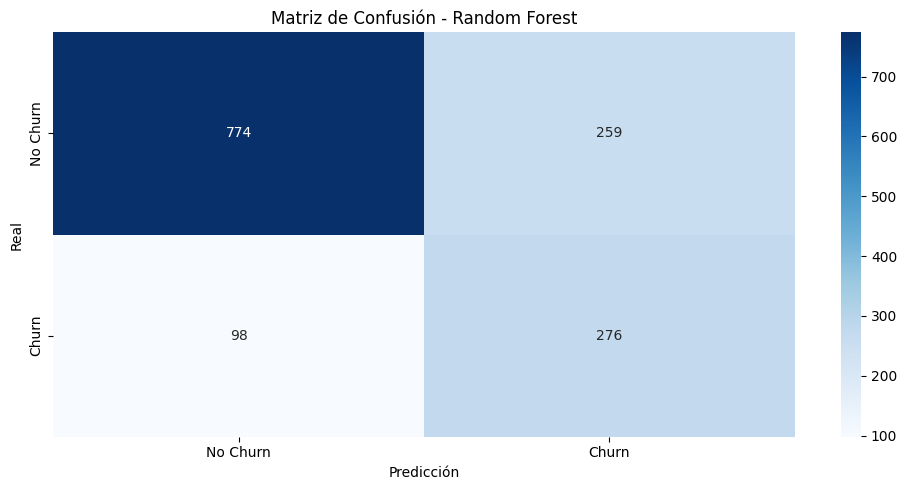

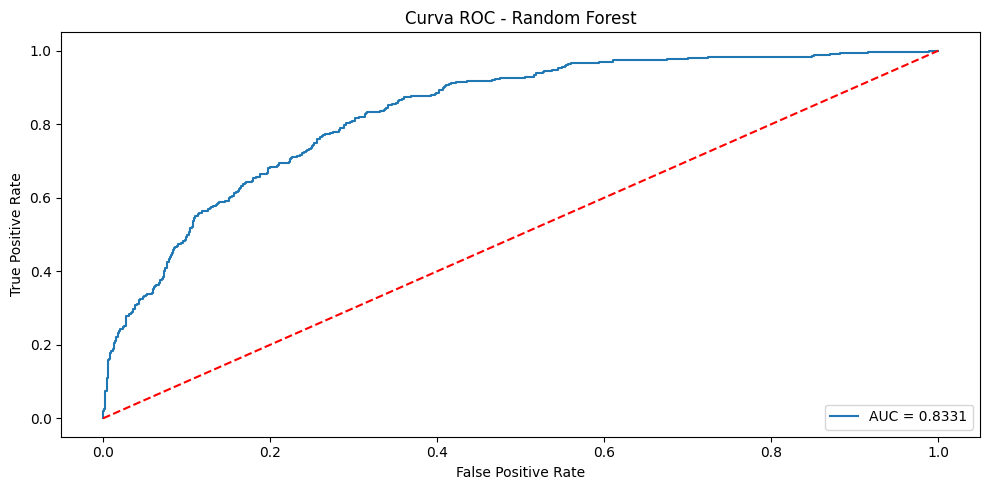


--- Evaluación XGBoost ---
Accuracy:        0.794598
Precision:       0.653430
Recall:          0.483957
F1-score:        0.556068
Tiempo predicción: 0.020151 segundos


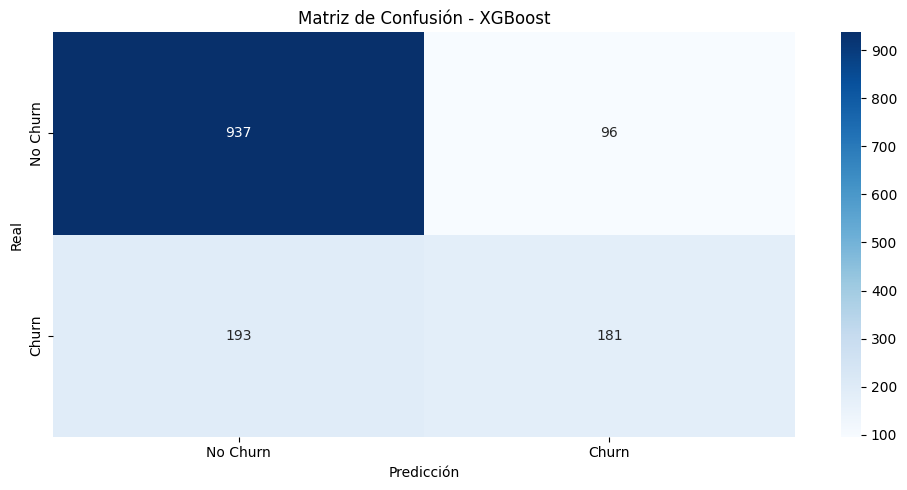

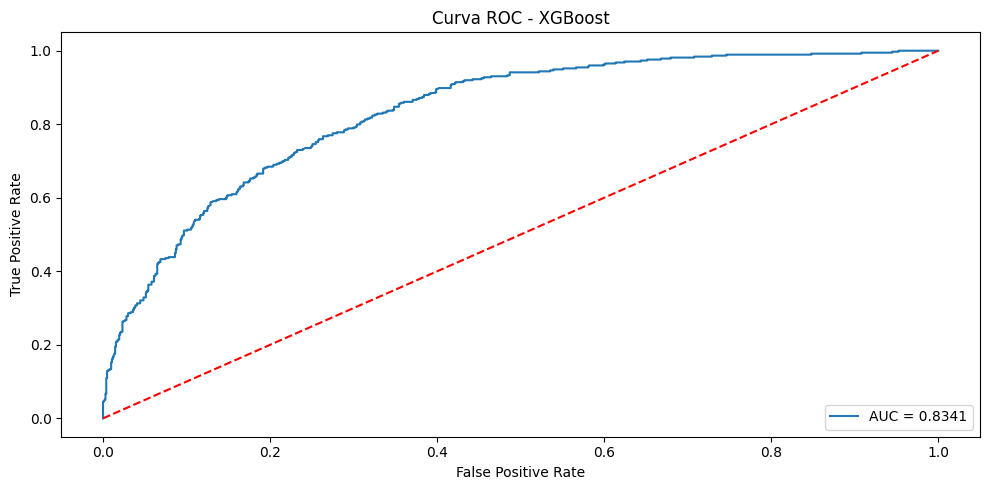


--- Evaluación Catboost ---
Accuracy:        0.737740
Precision:       0.504188
Recall:          0.804813
F1-score:        0.619979
Tiempo predicción: 0.028739 segundos


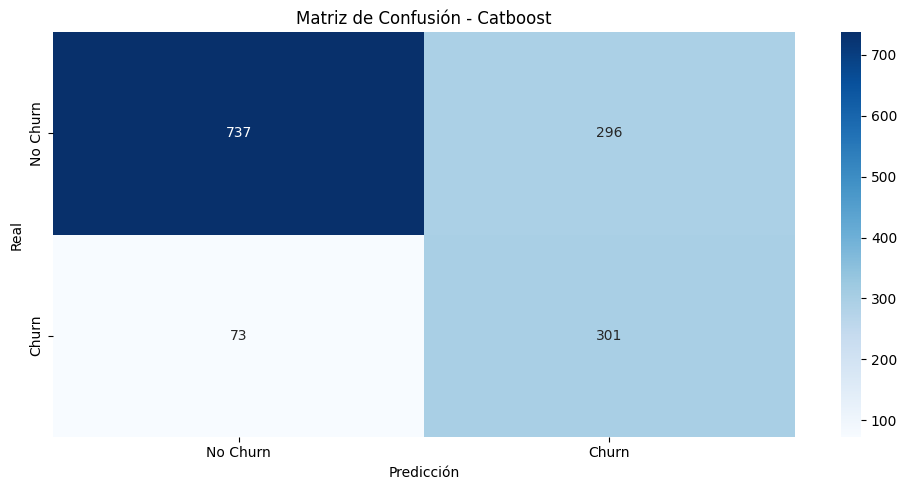

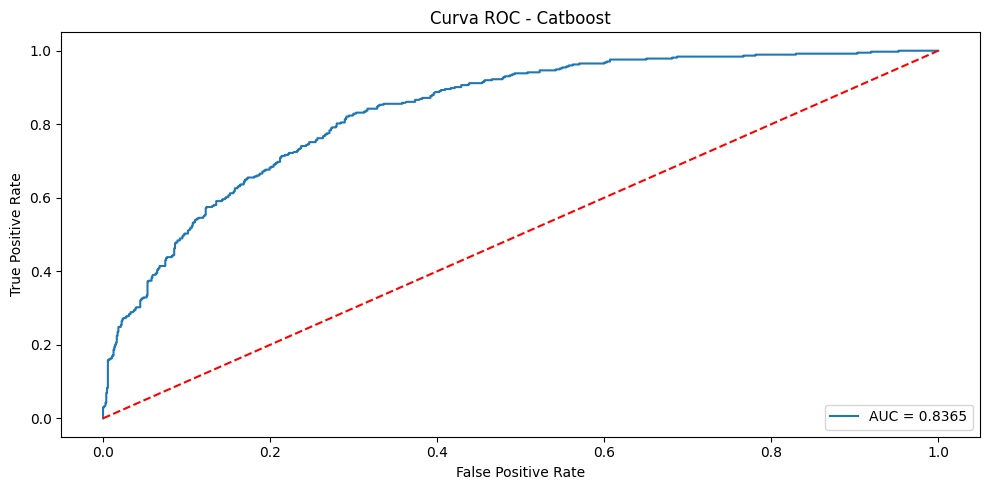


--- Evaluación LightGBM ---
Accuracy:        0.797441
Precision:       0.661818
Recall:          0.486631
F1-score:        0.560863
Tiempo predicción: 0.025746 segundos


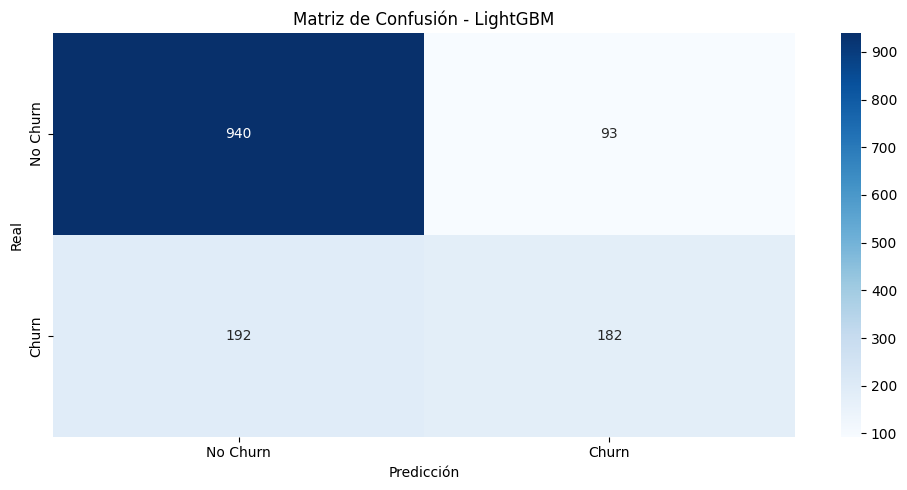

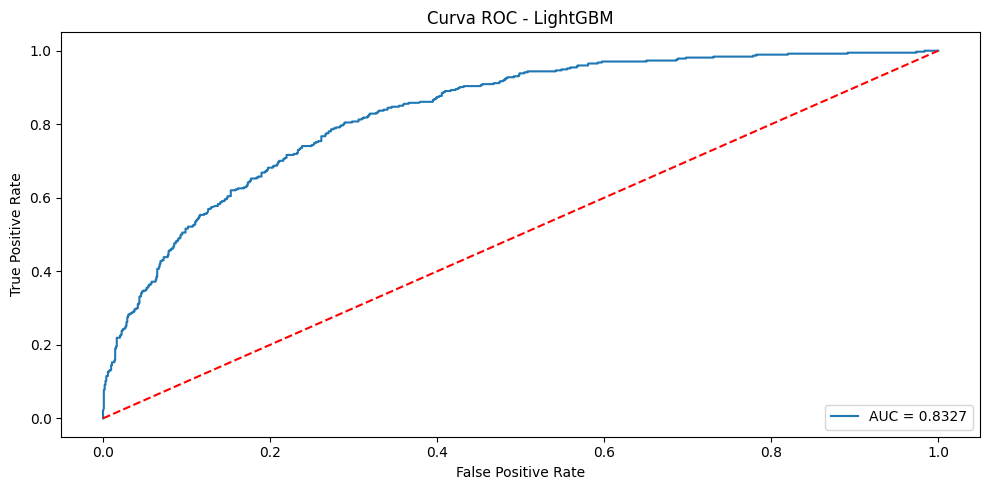

In [ ]:
final_models = {
    "Random Forest": grid_random_forest.best_estimator_,
    "XGBoost": grid_xgb.best_estimator_,
    "Catboost": grid_catboost.best_estimator_,
    "LightGBM": grid_lgbm.best_estimator_
}

for name, model in final_models.items():
    print(f"\n--- Evaluación {name} ---")
    
    start_time = time.time()
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    end_time = time.time()
    pred_time = end_time - start_time
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy:        {acc:.6f}")
    print(f"Precision:       {prec:.6f}")
    print(f"Recall:          {rec:.6f}")
    print(f"F1-score:        {f1:.6f}")
    print(f"Tiempo predicción: {pred_time:.6f} segundos")
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Churn", "Churn"],
                yticklabels=["No Churn", "Churn"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusión - {name}")
    plt.tight_layout()
    plt.show()
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Curva ROC - {name}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

**Ranking de Modelos por AUC-ROC**

- CatBoost — 0.8365 
- XGBoost — 0.8341
- RandomForest — 0.8331
- LightGBM — 0.8327

**Análisis por Modelo**

- `CatBoost` - Modelo líder y especialista en recall

    * Recall más alto (0.8048): Excelente para detectar casos positivos
    * Precisión más baja (0.5042): Alto costo en falsos positivos
    * F1-score (0.6200): Mejor balance entre precisión y recall
    * AUC líder (0.8365): Mejor capacidad discriminativa general

- `LightGBM` - Excelente precisión y accuracy

    * Máxima precisión (0.6618): Mejor control de falsos positivos
    * Accuracy más alto (0.7974): Clasificación general más efectiva
    * Recall moderado (0.4866): Capacidad media para detectar casos positivos
    * F1-score (0.5609): Balance aceptable pero mejorable

- `XGBoost` - Modelo solido

    * Precisión sólida (0.6534): Muy cercano a LightGBM en control de falsos positivos
    * Recall bajo (0.4840): Similar limitación en detección de casos positivos
    * F1-score (0.5561): Performance muy similar a LightGBM
    * AUC competitivo (0.8341): Buena capacidad discriminativa

- `Random Forest` - Rendimiento Medio

    * Recall sólido (0.7380): Buena detección de casos positivos
    * Precisión limitada (0.5159): Problemas con falsos positivos
    * F1-score (0.6073): Segundo mejor balance general
    * AUC competitivo (0.8331): Similar a otros modelos

**Hallazgos Clave**

- Precisión-focused: LightGBM y XGBoost (evitan falsos positivos)
- Recall-focused: CatBoost y Random Forest (maximizan detección)
- Consistencia en AUC: Todos los modelos tienen AUC muy similar (0.8327-0.8365), confirmando que todos discriminan igualmente bien entre clases

En conjunto, todos los modelos presentan tiempos de predicción muy bajos (inferiores a 0.08 segundos), por lo que todos son aptos para entornos de producción en tiempo real o sistemas interactivos. No obstante, si se prioriza la eficiencia computacional, Catboost, LightGBM y XGBoost ofrecen la mejor relación entre velocidad y rendimiento predictivo.

**Recomendación final**

`CatBoost` emerge como el modelo más robusto considerando:

- Mejor F1-score (0.6200): Balance óptimo entre precisión y recall
- Mejor AUC (0.8365): Máxima capacidad discriminativa
- Recall excelente (0.8048): Detecta el 80% de los casos de churn

### **Resumen de Métricas de Evaluación en Conjunto de Prueba**

| Modelo | AUC-ROC | Precision | Recall | F1-Score | Accuracy | Tiempo de predicción |
|--------|----------|-----------|--------|----------| ----------| ----------|
| **Catboost** | 0.8365 | 0.504188 | 0.804813 | 0.619979 | 0.737740 |  0.028739 segundos |
| **XGBoost** | 0.8341 | 0.653430 | 0.483957 | 0.556068 | 0.794598 |  0.020151 segundos |
| **RandomForest** | 0.8331 | 0.515888 | 0.737968 | 0.607261 | 0.746269 | 0.071758 segundos |
| **LightGBM** | 0.8327 | 0.661818 | 0.486631 | 0.560863 | 0.797441 | 0.025746 segundos |


## **Feature importance**

Para comprender qué factores son más determinantes en las predicciones de los modelos, se implementó una función especializada que visualiza las características más importantes de los algoritmos basados en árboles. Este análisis permite identificar las variables que tienen mayor poder predictivo según cada modelo

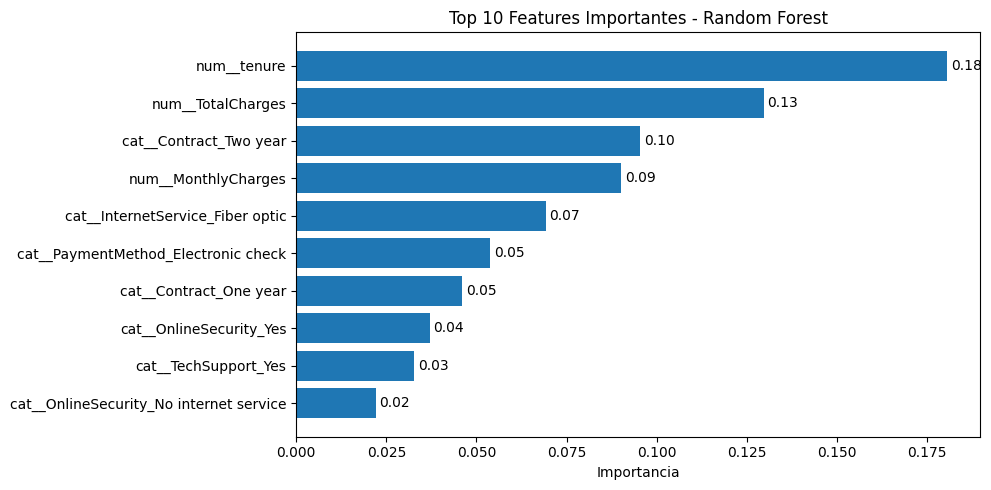

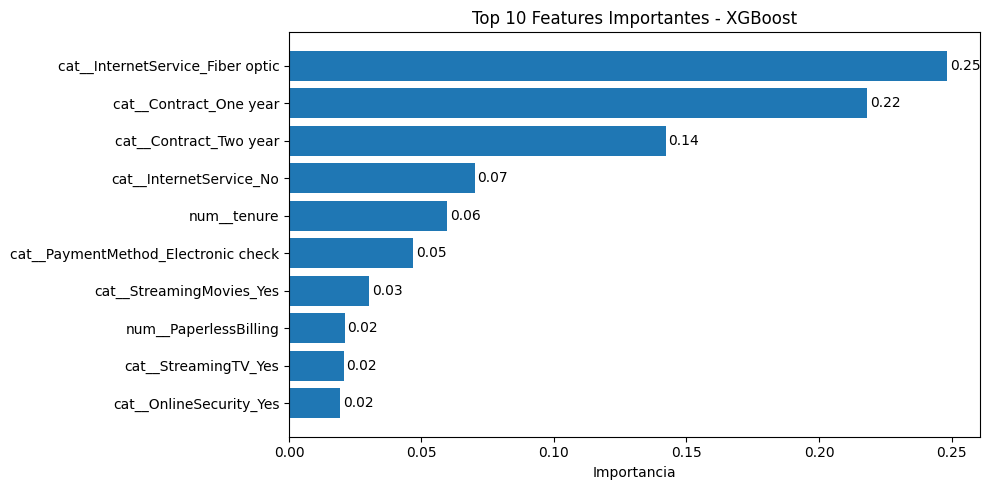

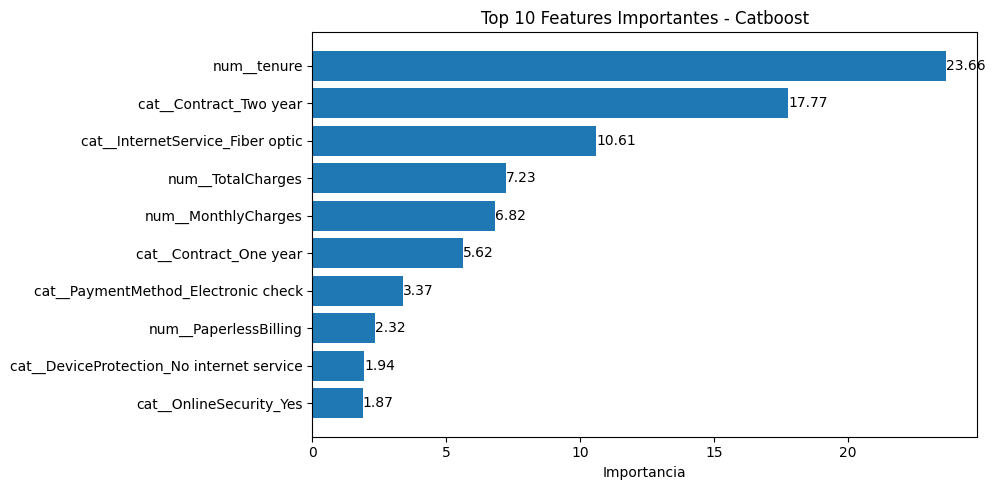

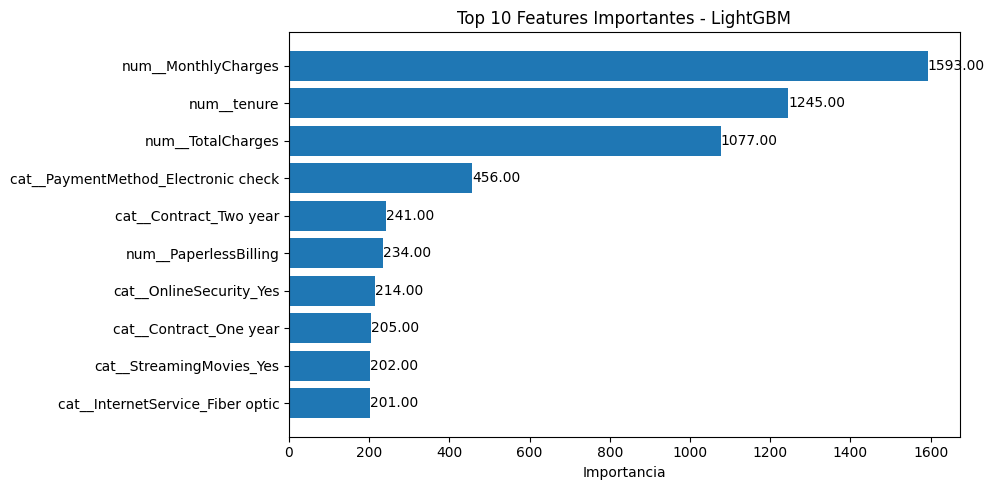

In [12]:
def plot_feature_importances(model, model_name, feature_names, top_n=10):
    importances = model.named_steps["classifier"].feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]

    plt.figure(figsize=(10, 5))
    bars = plt.barh(range(len(indices)), importances[indices], align="center")
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.gca().invert_yaxis()
    plt.xlabel("Importancia")
    plt.title(f"Top {top_n} Features Importantes - {model_name}")

    for i, bar in enumerate(bars):
        plt.text(
            bar.get_width() + 0.001,  
            bar.get_y() + bar.get_height()/2,  
            f"{importances[indices][i]:.2f}",  
            va="center"
        )

    plt.tight_layout()
    plt.show()

feature_names_random_forest = grid_random_forest.best_estimator_.named_steps["preprocessing"].get_feature_names_out()
feature_names_xgb = grid_xgb.best_estimator_.named_steps["preprocessing"].get_feature_names_out()
feature_names_catboost = grid_catboost.best_estimator_.named_steps["preprocessing"].get_feature_names_out()
feature_names_lgbm = grid_lgbm.best_estimator_.named_steps["preprocessing"].get_feature_names_out()


plot_feature_importances(grid_random_forest.best_estimator_, "Random Forest", feature_names_random_forest)
plot_feature_importances(grid_xgb.best_estimator_, "XGBoost", feature_names_xgb)
plot_feature_importances(grid_catboost.best_estimator_, "Catboost", feature_names_catboost)
plot_feature_importances(grid_lgbm.best_estimator_, "LightGBM", feature_names_lgbm)

**Análisis por Modelo**

* `XGBoost` - Modelo Más Enfocado

    *    Dominio absoluto de Fibra Óptica (0.25): Característica más influyente por amplio margen
    *    Contratos como segundo factor (0.22 + 0.14): Confirmación de su importancia crítica
    *    Patrón claro: Prefiere características categóricas sobre numéricas

    Modelo muy enfocado en tipo de servicio y compromiso contractual

* `Random Forest` - Modelo Más Balanceado

    *   Antigüedad como líder (0.18): El tiempo como cliente es el factor principal
    *   Distribución equitativa: Mezcla balanceada de variables numéricas y categóricas
    *   Enfoque conservador: Considera múltiples factores con similar importancia

    Valora tanto comportamiento temporal como características de servicio

* `CatBoost` - Especialista en Variables Temporales

    *   Antigüedad dominante (23.66): Claramente la variable más importante
    *   Contratos y Fibra como soporte: Segundas características en importancia
    *   Patrón claro: Prioriza variables numéricas y de tiempo

    Modelo que premia la lealtad y permanencia del cliente

* `LightGBM` - Enfoque en Variables Económicas

    *   Cargos Mensuales como líder (1593): Importancia abrumadora de factores económicos
    *   Antigüedad y Cargos Totales: Refuerzo del componente económico-temporal
    *   Métrica diferente: Valores absolutos mucho más altos pero patrón consistente

    Modelo que prioriza el valor económico sobre otros factores

**Estrategias de Retención Priorizadas:**

- Focalizar migración a contratos largos - Máximo impacto esperado
- Programas de fidelización para primeros meses - Retener durante período crítico
- Revisar estrategia de Fibra Óptica - Alto riesgo de churn confirmado
- Incentivar pagos automáticos - Reducir dependencia de electronic check

## **Carga modelos**

In [13]:
import joblib

ruta_modelos = os.path.join("..", "app/models.joblib")

joblib.dump(final_models, ruta_modelos)

['..\\app/models.joblib']